### Load style and content

In [6]:
import tensorflow as tf
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
CONTENT_FILENAME = "AllStar.mp3" #"iputs/imperial.mp3"
STYLE_FILENAME = "TuningNote.mp3" #"inputs/usa.mp3"

In [8]:
display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [9]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectum(filename): 
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT) #short time fourier transform, x = audio file, N_FFT = window size of FFT
    p = np.angle(S)
    S = np.log1p(np.abs(S[:,:430])) #??? returns natural logarithm of spectrogram? 
    return S, fs

In [10]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME) #turns audio file into spectrogram array
a_style, fs = read_audio_spectum(STYLE_FILENAME) #turns audio file into spectrogram array 

N_SAMPLES = a_content.shape[1] #time?
N_CHANNELS = a_content.shape[0] #frequencies?
a_style = a_style[:N_CHANNELS, :N_SAMPLES] #restricting the size of the style to the content (bad code?)


## Tonnetz

In [11]:
def tonnetzfeatures(audiopath): #computing a samples position in tonal centroid space (six dimensions, collections of pitches)
    audio, samplingrate = librosa.load(audiopath) #(more info: http://www.ofai.at/~martin.gasser/papers/oefai-tr-2006-13.pdf)
    audio = librosa.effects.harmonic(audio) #extracts harmonic elements from audio
    tonnetz = librosa.feature.tonnetz(y=audio,sr=samplingrate) #librosa's tonnetz function
    print(tonnetz)
    
tonnetzfeatures(CONTENT_FILENAME) #locations in tonal centroid space over time x: undefined (430?) y: 6 dimensional tonal space

[[ -3.18671387e-01  -1.54659223e-01  -5.04832758e-02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -3.77856048e-02  -2.14427123e-02   3.17131127e-04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -1.79320467e-01  -4.07095081e-02   7.37461013e-03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -1.81115980e-01  -5.90001229e-02   4.81427596e-02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  6.63154812e-03   4.72204820e-03   1.05258915e-02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  8.32147675e-02   2.34209969e-02   1.34556472e-02 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


### Visualize spectrograms for content and style tracks

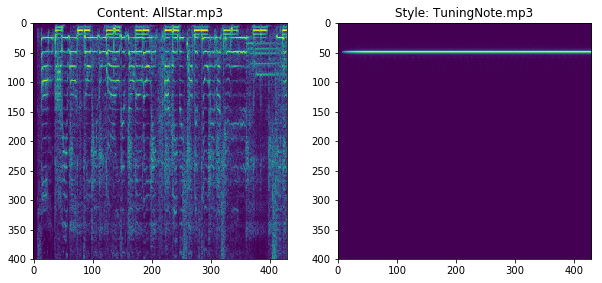

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content: ' + CONTENT_FILENAME)
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style: ' + STYLE_FILENAME)
plt.imshow(a_style[:400,:])
plt.show()

### Compute content and style feats

In [13]:
N_FILTERS = 4096 

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:]) 
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:]) 

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11)) #standard deviation calculation 
kernel = np.random.randn(11, 11, N_CHANNELS, N_FILTERS)*std #returns an array of 1x11xFREQUENCIESxFILTERS with random numbers

g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x") #only takes 1 frequency at a time, does this N_CHANNELS times

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32') #filter weights
  
    conv = tf.nn.conv2d(
        x, #input
        kernel_tf, #filter weights
        strides=[1, 1, 1, 1], #1d convolution on every pixel of a certain frequency spectrogram
        padding="SAME",
        name="conv")
    
    net = tf.nn.relu(conv) #changing all negatives to zero

    content_features = net.eval(feed_dict={x: a_content_tf}) #extracting tf content from x
    print(content_features)
    print(content_features.shape)

    
    style_features = net.eval(feed_dict={x: a_style_tf}) #extracting tf style from x
    #print(style_features.shape)
    
    
    features = np.reshape(style_features, (-1, N_FILTERS)) #reshapes style_features to 420x4096 from (1x1x420x4096)
    #print(features.shape)
    
    style_gram = np.matmul(features.T, features) / N_SAMPLES #dot product / 4096, matrix multiplciation of transpose(features) * features, 

[[[[ 0.          0.          0.         ...,  0.00216305  0.          0.00566177]
   [ 0.          0.          0.         ...,  0.04420631  0.          0.08362725]
   [ 0.          0.          0.         ...,  0.14756879  0.06751221
     0.22633407]
   ..., 
   [ 1.2230978   0.41885722  0.         ...,  0.          0.          0.        ]
   [ 0.88629609  0.99845707  0.         ...,  0.          0.          0.        ]
   [ 0.90079141  0.73353356  0.         ...,  0.06499139  0.          0.        ]]]]
(1, 1, 430, 4096)


### Optimize

In [ ]:
from sys import stderr

ALPHA= 1e-2 #CONTENT V.S STYLE RATEa
learning_rate= 1e-3 
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
#     x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")

    #returns random tensor of size 1x1xTIMExFREQUENCIES
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x") 
    
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32') #random filter weights from before
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="SAME",
        name="conv")
    
    
    net = tf.nn.relu(conv) #turns all negatives to zero
    print(net.shape)
    

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features) #calculating content loss using euclidean distance, (to be changed to tonnetz)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape()) #lambda function that gets net's dimensions into variables

    size = height * width * number 
    feats = tf.reshape(net, (-1, number)) #reduces unused dimensions
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES #dot product
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram) #computing style loss from two dot products

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        print(net.eval())
        print('Started optimization.')
        opt.minimize(sess)
    
       
        result = x.eval()

(1, 1, 430, 4096)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
[[[[  0.00000000e+00   2.21733950e-04   3.38927930e-04 ...,
      9.80671495e-04   1.02569815e-03   0.00000000e+00]
   [  0.00000000e+00   2.49326404e-04   4.88851103e-04 ...,
      1.34067959e-03   6.43010193e-04   2.46663229e-04]
   [  8.42256588e-04   3.66344408e-04   5.74104779e-04 ...,
      0.00000000e+00   5.44012073e-05   5.10768150e-04]
   ..., 
   [  7.45002937e-04   1.76091038e-04   0.00000000e+00 ...,
      0.00000000e+00   8.76934675e-04   1.10335753e-03]
   [  9.90784960e-04   1.15231378e-04   6.46949455e-04 ...,
      7.25048827e-04   2.60327768e-04   0.00000000e+00]
   [  0.00000000e+00   6.19132246e-04   3.95161594e-04 ...,
      4.36972477e-05   0.00000000e+00   4.01652302e-04]]]]
Started optimization.


### Invert spectrogram and save the result

In [11]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(1000):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'out.wav'
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [12]:
print (OUTPUT_FILENAME)
display(Audio(OUTPUT_FILENAME))

out.wav


### Visualize spectrograms

NameError: name 'a_content' is not defined

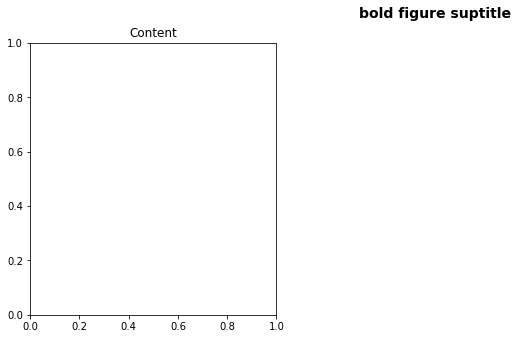

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content: ' + CONTENT_FILENAME)
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style: ' + STYLE_FILENAME)
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(np.log(a[:400,:]+2))
plt.show()